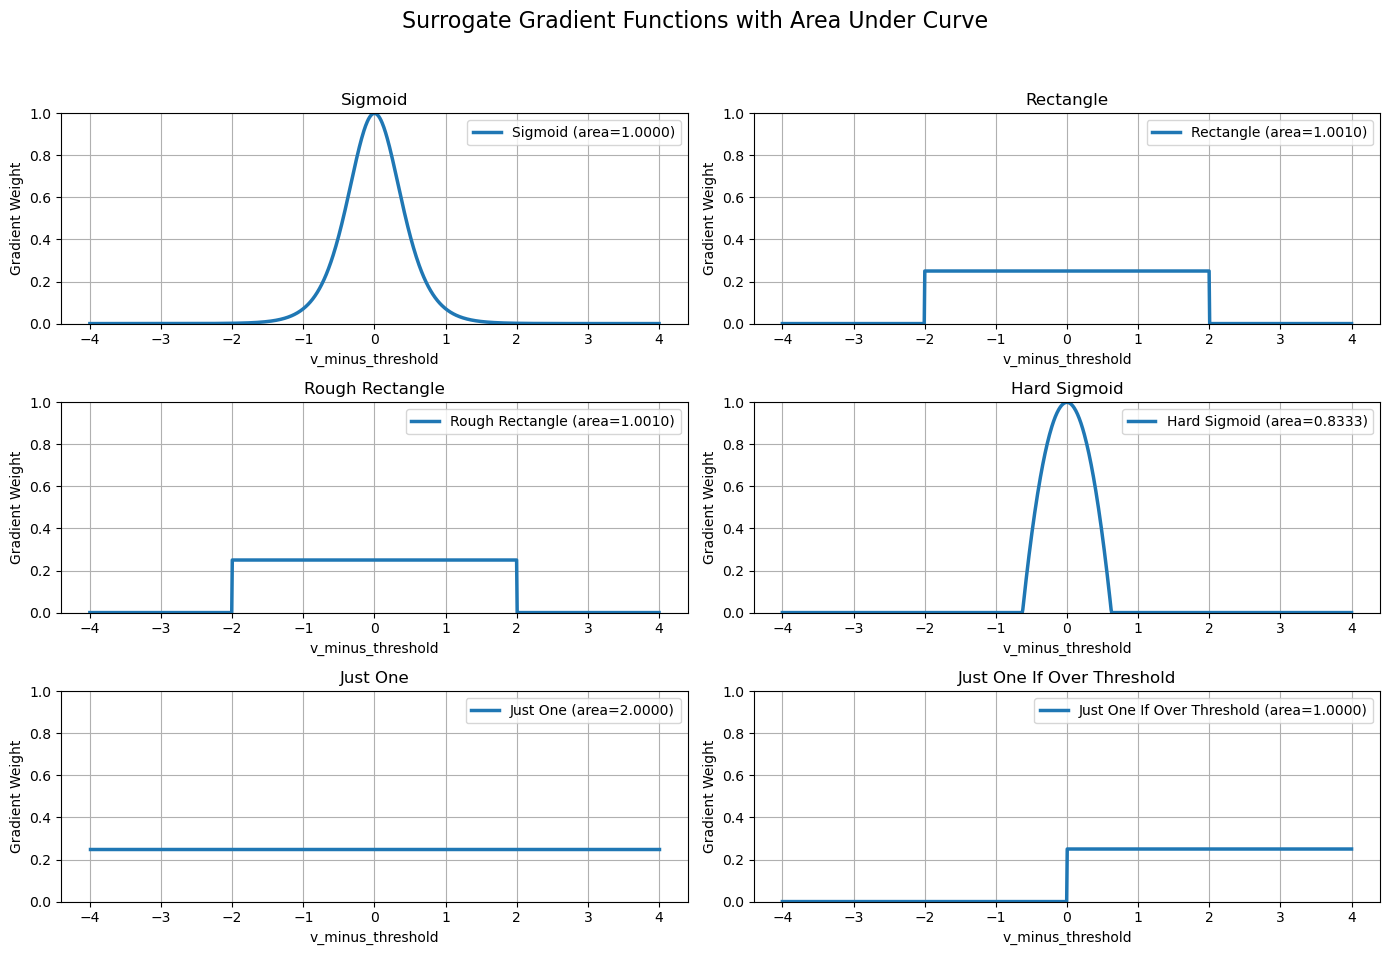

📐 Area under each surrogate gradient curve:
- Sigmoid: 1.000000
- Rectangle: 1.001001
- Rough Rectangle: 1.001001
- Hard Sigmoid: 0.833350
- Just One: 2.000000
- Just One If Over Threshold: 1.000000


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson

# surrogate 종류
surrogate_names = {
    1: "Sigmoid",
    2: "Rectangle",
    3: "Rough Rectangle",
    4: "Hard Sigmoid",
    5: "Just One",
    6: "Just One If Over Threshold"
}

# 설정
v = torch.linspace(-4, 4, steps=1000)
v2 = torch.linspace(-4, 4, steps=1000)
v_np = v2.numpy()
grad_output = torch.ones_like(v)
sg_width = 4.0

# subplot 설정
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

areas = {}  # 면적 저장용

for surrogate in range(1, 7):
    v_clone = v.clone()
    go = grad_output.clone()

    if surrogate == 1:
        alpha = sg_width
        sig = torch.sigmoid(alpha * v_clone)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 2:
        grad = (v_clone.abs() <= sg_width / 2).float() / sg_width
    elif surrogate == 3:
        go[v_clone.abs() > sg_width / 2] = 0
        grad = go / sg_width
    elif surrogate == 4:
        alpha = sg_width
        sig = torch.clamp(alpha * v_clone * 0.2 + 0.5, min=0, max=1)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 5:
        grad = torch.ones_like(v_clone) / sg_width
    elif surrogate == 6:
        go[v_clone < 0.0] = 0
        grad = go / sg_width

    grad_np = grad.numpy()
    area = simpson(grad_np, v_np)
    # area = np.trapz(grad_np, v_np)
    areas[surrogate_names[surrogate]] = area

    axs[surrogate - 1].plot(v_np, grad_np, label=f"{surrogate_names[surrogate]} (area={area:.4f})", linewidth=2.5)
    axs[surrogate - 1].set_title(surrogate_names[surrogate])
    axs[surrogate - 1].set_xlabel("v_minus_threshold")
    axs[surrogate - 1].set_ylabel("Gradient Weight")
    axs[surrogate - 1].grid(True)
    axs[surrogate - 1].set_ylim(0, 1)  # y축 고정
    axs[surrogate - 1].legend()

plt.suptitle("Surrogate Gradient Functions with Area Under Curve", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 면적 출력
print("📐 Area under each surrogate gradient curve:")
for name, area in areas.items():
    print(f"- {name}: {area:.6f}")


In [ ]:
sg_width = 6.0
# ===========surrogate gradient function (hard sigmoid)
alpha = sg_width  #alpha클수록 좁아짐
# sig = torch.clamp(alpha*v_minus_threshold * 0.2 + 0.5, min=0, max=1)
sig = torch.sigmoid(alpha*v_minus_threshold)
sg_temp = 4.0*sig*(1-sig) # max 1.0 여기까지는
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))  # 최대 표현 가능한 값
sg_temp *= sg_temp_max
scale_sg_temp = 2**math.ceil(math.log2(sg_temp_max / (2**(sg_bit-1) -1))) 
sg_temp = torch.clamp((sg_temp / scale_sg_temp).round(), -2**(sg_bit-1) + 1, 2**(sg_bit-1) - 1) * scale_sg_temp

grad_input = sg_temp*grad_output

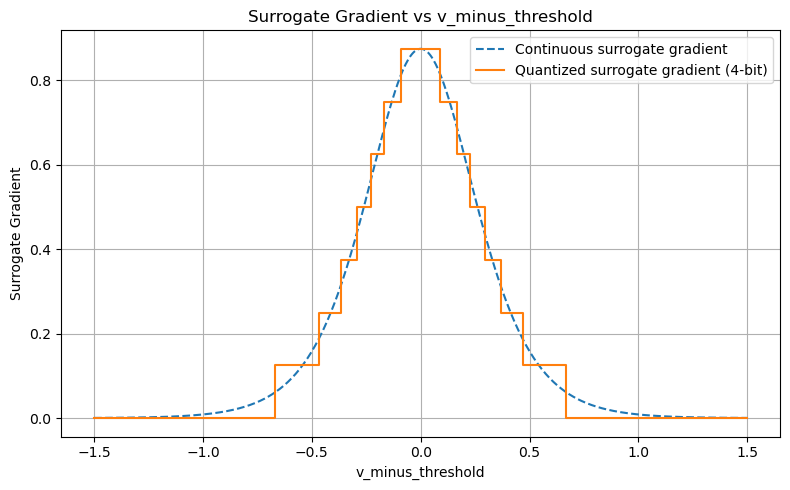

In [4]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Generate v_minus_threshold values
v_vals = torch.linspace(-1.5, 1.5, 500)
sig = torch.sigmoid(alpha * v_vals)
sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
sg_temp *= sg_temp_max

# Quantization
sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(v_vals, sg_temp, label="Continuous surrogate gradient", linestyle="--")
plt.step(v_vals, sg_temp_quantized, where='mid', label=f"Quantized surrogate gradient ({sg_bit}-bit)")
plt.xlabel("v_minus_threshold")
plt.ylabel("Surrogate Gradient")
plt.title("Surrogate Gradient vs v_minus_threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
import torch
import math

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Generate v_minus_threshold values
v_vals = torch.arange(0, 1.5 + 1/1024, 1/1024)
# v_vals = torch.arange(0, -1.5 - 1/1024, -1/1024)
# v_vals = torch.linspace(-1.5, 1.5, 3000)
sig = torch.sigmoid(alpha * v_vals)
sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
sg_temp *= sg_temp_max

# Quantization
sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp

# Detect where quantized value changes
change_indices = torch.nonzero(sg_temp_quantized[1:] != sg_temp_quantized[:-1], as_tuple=False).squeeze() + 1
v_change_points = v_vals[change_indices]
v_change_points_scaled = v_change_points * 1024
# v_change_points_scaled = v_change_points * 1024 + 512

# Output values
list_of_changes = [(float(v.item()), float(v_scaled.item())) for v, v_scaled in zip(v_change_points, v_change_points_scaled)]
print(len(list_of_changes))
list_of_changes



7


[(0.091796875, 94.0),
 (0.16796875, 172.0),
 (0.23046875, 236.0),
 (0.2939453125, 301.0),
 (0.3681640625, 377.0),
 (0.46875, 480.0),
 (0.6650390625, 681.0)]

In [28]:
import torch
import math

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Generate v_minus_threshold values
v_vals = torch.arange(0, 1.5 + 1/1024, 1/1024)
v_vals = torch.arange(0, -1.5 - 1/1024, -1/1024)
# v_vals = torch.linspace(-1.5, 1.5, 3000)
sig = torch.sigmoid(alpha * v_vals)
sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
sg_temp *= sg_temp_max

# Quantization
sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp

# Detect where quantized value changes
change_indices = torch.nonzero(sg_temp_quantized[1:] != sg_temp_quantized[:-1], as_tuple=False).squeeze() + 1
v_change_points = v_vals[change_indices]
v_change_points_scaled = v_change_points * 1024
# v_change_points_scaled = v_change_points * 1024 + 512

# Output values
list_of_changes = [(float(v.item()), float(v_scaled.item())) for v, v_scaled in zip(v_change_points, v_change_points_scaled)]
print(len(list_of_changes))
list_of_changes



torch.Size([3073])
14


[(-0.6640625, -680.0),
 (-0.4677734375, -479.0),
 (-0.3671875, -376.0),
 (-0.29296875, -300.0),
 (-0.2294921875, -235.0),
 (-0.1669921875, -171.0),
 (-0.0908203125, -93.0),
 (0.091796875, 94.0),
 (0.16796875, 172.0),
 (0.23046875, 236.0),
 (0.2939453125, 301.0),
 (0.3681640625, 377.0),
 (0.46875, 480.0),
 (0.6650390625, 681.0)]

In [30]:
def sg(input):
    sg_width = 6.0
    alpha = sg_width
    sg_bit = 4
    sg_temp_max = 1.0
    sg_temp_max -= 2 ** (-(sg_bit - 1))
    scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))
    
    sig = torch.sigmoid(alpha * input)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max

    # Quantization
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized

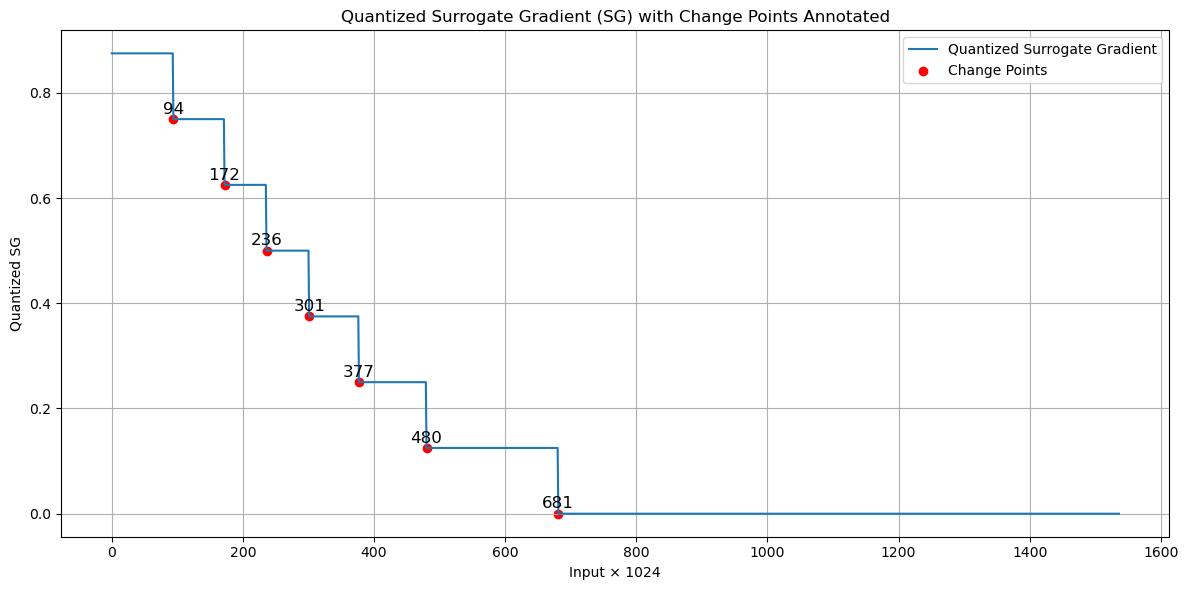

In [33]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Input range: 0 to 1.5 with step 1/1024
v_vals = torch.arange(0, 1.5 + 1/1024, 1/1024)

# Surrogate gradient function
def sg(input):
    sig = torch.sigmoid(alpha * input)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized

# Calculate quantized surrogate gradient
y = sg(v_vals)

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v_vals[change_indices] * 1024
y_change = y[change_indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_vals * 1024, y, label='Quantized Surrogate Gradient')
plt.scatter(x_change, y_change, color='red', label='Change Points')

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}', fontsize=12, ha='center', rotation=0)

plt.xlabel("Input × 1024")
plt.ylabel("Quantized SG")
plt.title("Quantized Surrogate Gradient (SG) with Change Points Annotated")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


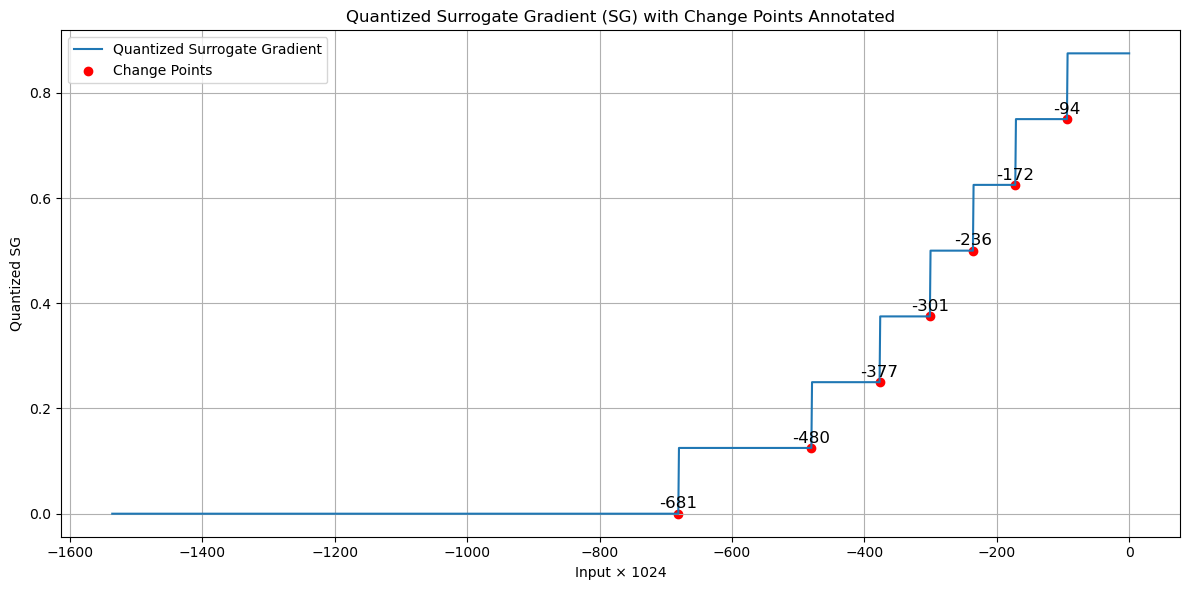

In [36]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Input range: 0 to 1.5 with step 1/1024
v_vals = torch.arange(0, -1.5 - 1/1024, -1/1024)

# Surrogate gradient function
def sg(input):
    sig = torch.sigmoid(alpha * input)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized

# Calculate quantized surrogate gradient
y = sg(v_vals)

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v_vals[change_indices] * 1024
y_change = y[change_indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_vals * 1024, y, label='Quantized Surrogate Gradient')
plt.scatter(x_change, y_change, color='red', label='Change Points')

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}', fontsize=12, ha='center', rotation=0)

plt.xlabel("Input × 1024")
plt.ylabel("Quantized SG")
plt.title("Quantized Surrogate Gradient (SG) with Change Points Annotated")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
